In [1345]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

In [1346]:
df = pd.read_csv('~/desktop/2014_data.tsv', delimiter='\t')

In [1347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55271 entries, 0 to 55270
Columns: 3148 entries, CASEID to GQTYPE2
dtypes: float64(38), int64(3110)
memory usage: 1.3 GB


In [1348]:
df.head()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,II2EMST4,PRXRETRY,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,GQTYPE2
0,1,85314767,1,99,99,16,9999,99,4,93,...,1,99,2,2,2,2,8587.828634,40025,2,-9
1,2,16240983,1,99,99,16,9999,99,1,1,...,1,99,1,1,2,2,4260.686570,40041,1,-9
2,3,95206287,2,99,99,991,9991,91,91,91,...,1,99,2,2,2,2,874.478772,40010,1,-9
3,4,91546127,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,4816.381147,40019,2,-9
4,5,43902390,2,99,99,991,9991,91,91,91,...,1,99,1,1,2,2,18967.391778,40016,2,-9


In [1349]:
df.columns

Index([u'CASEID', u'QUESTID2', u'CIGEVER', u'CIGOFRSM', u'CIGWILYR', u'CIGTRY',
       u'CIGYFU', u'CIGMFU', u'CIGREC', u'CIG30USE',
       ...
       u'II2EMST4', u'PRXRETRY', u'PDEN10', u'COUTYP2', u'MAIIN102',
       u'AIIND102', u'ANALWT_C', u'VESTR', u'VEREP', u'GQTYPE2'],
      dtype='object', length=3148)

In [1350]:
df.shape

(55271, 3148)

# FEATURE ENGINEERING

In [1352]:
def age_first_used(val):
    if val < 18:
        return 1
    elif val <= 21:
        return 2
    elif val <= 26:
        return 3
    elif val < 80:
        return 4
    else:
        return 5
    
df['age_first_used'] = df['MJAGE'].apply(age_first_used)
df['age_first_alc'] = df['ALCTRY'].apply(age_first_used)

In [1353]:
def days_past_year(val):
    if val < 13:
        return 4
    elif val < 53:
        return 3
    elif val < 180:
        return 2
    elif val <= 365:
        return 1
    else: 
        return 5

df['tot_days_past_year'] = df['MJYRTOT'].apply(days_past_year)

In [1354]:
def group_daypwk(val):
    if val < 2:
        return 3
    elif val < 5:
        return 2
    elif val < 8:
        return 1
    else:
        return 4

df['days_per_week_past_year'] = df['MRDAYPWK'].apply(group_daypwk)
df['days_per_week_alc'] = df['ALDAYPWK'].apply(group_daypwk)

In [1355]:
df['last_used'] = df['MJREC'].replace([11, 8, 9, 91, 97, 98], [1, 2, 3, 4, 4, 4])

In [1356]:
df['days_used_past_month'] = df['MR30EST'].replace([91,93,94,97,98,99],[7,7,7,7,7,7])

In [1357]:
df['religious_importance'] = df['SNRLGIMP'].replace([85, 94, 97, 98, 99], [5,5,5,5,5])

In [1358]:
def binge_drinking(val):
    if val <= 2:
        return 5
    elif val <= 4:
        return 4
    elif val <= 7:
        return 3
    elif val <= 10: 
        return 2
    else:
        return 1 
    
df['days_5plusdrinks_past_mo'] = df['DR5DAY']    

In [1359]:
df['age'] = df['CATAG7']

In [1360]:
df['gender'] = df['IRSEX']

In [1361]:
df['race'] = df['NEWRACE2']

In [1362]:
df['education'] = df['EDUCCAT2']

In [1363]:
df['work_situation_past_wk'] = df['JBSTATR2']

In [1364]:
df['tot_fam_income'] = df['IRFAMIN3']

## Check the value counts of features

In [1365]:
df.columns

Index([u'CASEID', u'QUESTID2', u'CIGEVER', u'CIGOFRSM', u'CIGWILYR', u'CIGTRY',
       u'CIGYFU', u'CIGMFU', u'CIGREC', u'CIG30USE',
       ...
       u'last_used', u'days_used_past_month', u'religious_importance',
       u'days_5plusdrinks_past_mo', u'age', u'gender', u'race', u'education',
       u'work_situation_past_wk', u'tot_fam_income'],
      dtype='object', length=3163)

In [1366]:
df['age_first_alc'].value_counts()

1    25271
5    15120
2    12601
3     1689
4      590
Name: age_first_alc, dtype: int64

In [1367]:
df['last_used'].value_counts()

4    31810
3    13925
1     5835
2     3701
Name: last_used, dtype: int64

In [1368]:
df['age_first_used'].value_counts()

5    31990
1    14776
2     6258
3     1485
4      762
Name: age_first_used, dtype: int64

In [1369]:
df['tot_days_past_year'].value_counts()

5    45930
4     3140
1     2850
3     1722
2     1629
Name: tot_days_past_year, dtype: int64

In [1370]:
df['days_per_week_past_year'].value_counts()

4    51763
1     1837
2     1169
3      502
Name: days_per_week_past_year, dtype: int64

In [1371]:
df['days_used_past_month'].value_counts()

7    55213
6       11
1       11
5       10
2       10
4        8
3        8
Name: days_used_past_month, dtype: int64

## Define X vector(s) and y vector.

In [1372]:
X = df[['age_first_used', 'age_first_alc', 'tot_days_past_year', 'days_per_week_past_year', 'days_per_week_alc', 
    'last_used', 'days_used_past_month', 'age', 'gender', 'race', 'education', 'work_situation_past_wk',
       'days_5plusdrinks_past_mo', 'tot_fam_income', 'religious_importance']]

In [1373]:
X.shape

(55271, 15)

In [1374]:
problem = (df['MRJSERPB'] == 1) | (df['MRJNDMOR'] == 1) | (df['MRJEMCTD'] == 1) | (df['MRJLSACT'] == 1)
no_problem = (df['MRJSERPB'] == 2) | (df['MRJNDMOR'] == 2) | (df['MRJEMCTD'] == 2) | (df['MRJLSACT'] == 2)
df_responses = df[problem | no_problem]

In [1375]:
df_responses = df_responses.copy()

In [1376]:
df_responses['y'] = np.zeros(df_responses.shape[0])

In [1377]:
df_responses.head()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,days_used_past_month,religious_importance,days_5plusdrinks_past_mo,age,gender,race,education,work_situation_past_wk,tot_fam_income,y
1,2,16240983,1,99,99,16,9999,99,1,1,...,7,3,1,4,1,1,3,2,2,0.0
8,9,45642490,2,99,99,991,9991,91,91,91,...,7,2,1,7,1,1,3,4,7,0.0
12,13,99692998,1,99,99,12,9999,99,3,93,...,7,3,1,5,1,1,2,1,6,0.0
17,18,67107154,1,99,99,15,9999,99,1,25,...,7,1,15,7,1,1,4,1,7,0.0
18,19,89015615,1,99,99,19,9999,99,1,30,...,7,1,8,7,1,7,3,1,5,0.0


In [1378]:
df_responses.loc[problem,'y'] = 1 #go to index row for 'problem' people and turn the zero into a one in column y

In [1379]:
df_responses.head()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,days_used_past_month,religious_importance,days_5plusdrinks_past_mo,age,gender,race,education,work_situation_past_wk,tot_fam_income,y
1,2,16240983,1,99,99,16,9999,99,1,1,...,7,3,1,4,1,1,3,2,2,1.0
8,9,45642490,2,99,99,991,9991,91,91,91,...,7,2,1,7,1,1,3,4,7,1.0
12,13,99692998,1,99,99,12,9999,99,3,93,...,7,3,1,5,1,1,2,1,6,1.0
17,18,67107154,1,99,99,15,9999,99,1,25,...,7,1,15,7,1,1,4,1,7,0.0
18,19,89015615,1,99,99,19,9999,99,1,30,...,7,1,8,7,1,7,3,1,5,0.0


In [1380]:
df_responses['y'].value_counts()

0.0    5166
1.0    2150
Name: y, dtype: int64

In [1381]:
X = df_responses[['age_first_used', 'age_first_alc', 'tot_days_past_year', 'days_per_week_past_year', 'days_per_week_alc', 
    'last_used', 'days_used_past_month', 'age', 'gender', 'race', 'education', 'work_situation_past_wk',
       'days_5plusdrinks_past_mo', 'tot_fam_income', 'religious_importance']]
y = df_responses['y']
df_final = pd.concat([X, y], axis=1)

In [1382]:
df_final.head()

,age_first_used,age_first_alc,tot_days_past_year,days_per_week_past_year,days_per_week_alc,last_used,days_used_past_month,age,gender,race,education,work_situation_past_wk,days_5plusdrinks_past_mo,tot_fam_income,religious_importance,y
1,1,1,2,2,4,1,7,4,1,1,3,2,1,2,3,1.0
8,2,2,1,1,2,1,7,7,1,1,3,4,1,7,2,1.0
12,1,1,1,4,2,1,7,5,1,1,2,1,1,6,3,1.0
17,1,1,2,4,4,1,7,7,1,1,4,1,15,7,1,0.0
18,1,1,4,4,2,1,7,7,1,7,3,1,8,5,1,0.0


In [1383]:
df_final.shape

(7316, 16)

# STRATIFIED KFOLD

In [1384]:
from sklearn.model_selection import StratifiedKFold #splits it evenly do i don't lose valuable y vector.
skf = StratifiedKFold(n_splits=5, random_state = 42)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [1457 1459 1460 ..., 7313 7314 7315] TEST: [   0    1    2 ..., 1477 1478 1479]
TRAIN: [   0    1    2 ..., 7313 7314 7315] TEST: [1457 1459 1460 ..., 2938 2939 2941]
TRAIN: [   0    1    2 ..., 7313 7314 7315] TEST: [2890 2892 2901 ..., 4412 4414 4416]
TRAIN: [   0    1    2 ..., 7313 7314 7315] TEST: [4318 4323 4324 ..., 5898 5901 5902]
TRAIN: [   0    1    2 ..., 5898 5901 5902] TEST: [5775 5777 5782 ..., 7313 7314 7315]


# RANDOM FOREST

In [1385]:
from sklearn.ensemble import RandomForestClassifier

In [1386]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, min_samples_leaf=1, max_features=2, n_jobs=-1, class_weight='balanced_subsample')
rfmodel1.fit(X_train,y_train);

In [1387]:
rfmodel1_pred = rfmodel1.predict_proba(X_test)[:,1]

In [1388]:
rfmodel1_pred

array([ 0.456,  0.326,  0.418, ...,  0.216,  0.116,  0.15 ])

In [1389]:
zip(rfmodel1.feature_importances_,X_train.columns)

[(0.029792313814023783, 'age_first_used'),
 (0.030101539532630429, 'age_first_alc'),
 (0.10020538888679226, 'tot_days_past_year'),
 (0.059999195245236704, 'days_per_week_past_year'),
 (0.054041753064366489, 'days_per_week_alc'),
 (0.025543826762848554, 'last_used'),
 (0.0034159358762188268, 'days_used_past_month'),
 (0.091080144527866058, 'age'),
 (0.033695749906315083, 'gender'),
 (0.068764316476802631, 'race'),
 (0.072236141155532951, 'education'),
 (0.1004994910062212, 'work_situation_past_wk'),
 (0.13691386235035508, 'days_5plusdrinks_past_mo'),
 (0.11955619861044607, 'tot_fam_income'),
 (0.074154142784343832, 'religious_importance')]

# PLOT IT

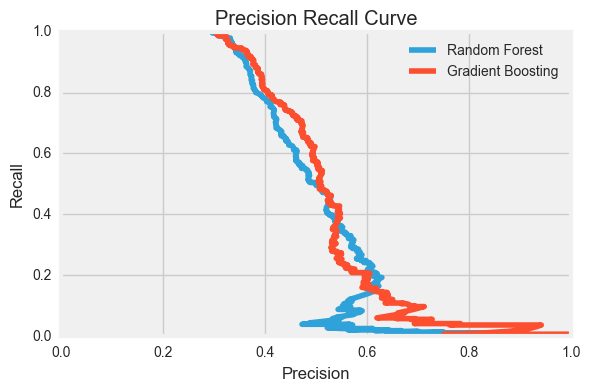

In [1390]:
precision_rf, recall_rf, threshold_rf = metrics.precision_recall_curve(y_test,rfmodel1_pred)

plt.plot(precision_rf, recall_rf, label='Random Forest')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.tight_layout();

precision_gb, recall_gb, threshold_gb = metrics.precision_recall_curve(y_test,gb1_test_pred)

plt.plot(precision_gb[:-1], recall_gb[:-1], label='Gradient Boosting')
# is number of ones - recall you are leaving behind.
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.tight_layout();

plt.legend(loc=1)

In [1391]:
#increasing recall means i am catching more people who are not necessarily addicts (yet) but has the potential, because
#it is misclassifying people. people who have no predisposition to addiction but model is being conservative to say yes.
#higher precision means i am catching all the addicts.

In [1392]:
precision_rf

array([ 0.29634735,  0.29606625,  0.29627072,  0.29647547,  0.29709141,
        0.29770992,  0.29742877,  0.29846583,  0.2993007 ,  0.29971989,
        0.30014025,  0.30119634,  0.30140845,  0.30162086,  0.30204658,
        0.30225989,  0.3024735 ,  0.30333097,  0.30369844,  0.30456491,
        0.3047823 ,  0.30587393,  0.30741541,  0.30763689,  0.30852601,
        0.30824891,  0.30836364,  0.30948905,  0.30994152,  0.3110785 ,
        0.31153564,  0.31222386,  0.31407407,  0.31430689,  0.31524164,
        0.31547619,  0.31641791,  0.31661677,  0.31685393,  0.31756757,
        0.3185241 ,  0.31924528,  0.32216299,  0.32186544,  0.32359723,
        0.32434515,  0.32534776,  0.32559938,  0.32762646,  0.32788162,
        0.32813718,  0.32942097,  0.32967894,  0.33019608,  0.33045526,
        0.33175729,  0.33123028,  0.33200953,  0.33227345,  0.33306709,
        0.33333333,  0.33413849,  0.33440774,  0.33467742,  0.33522267,
        0.33549433,  0.33549959,  0.33577832,  0.33743842,  0.33

In [1393]:
np.max(precision_rf[:-2])

1.0

In [1394]:
recall_rf

array([ 1.        ,  0.99767442,  0.99767442,  0.99767442,  0.99767442,
        0.99767442,  0.99534884,  0.99534884,  0.99534884,  0.99534884,
        0.99534884,  0.99534884,  0.99534884,  0.99534884,  0.99534884,
        0.99534884,  0.99534884,  0.99534884,  0.99302326,  0.99302326,
        0.99302326,  0.99302326,  0.99302326,  0.99302326,  0.99302326,
        0.99069767,  0.98604651,  0.98604651,  0.98604651,  0.98604651,
        0.98604651,  0.98604651,  0.98604651,  0.98604651,  0.98604651,
        0.98604651,  0.98604651,  0.98372093,  0.98372093,  0.98372093,
        0.98372093,  0.98372093,  0.98372093,  0.97906977,  0.97906977,
        0.97906977,  0.97906977,  0.97906977,  0.97906977,  0.97906977,
        0.97906977,  0.97906977,  0.97906977,  0.97906977,  0.97906977,
        0.97906977,  0.97674419,  0.97209302,  0.97209302,  0.96976744,
        0.96976744,  0.96511628,  0.96511628,  0.96511628,  0.9627907 ,
        0.9627907 ,  0.96046512,  0.95813953,  0.95581395,  0.95

In [1395]:
threshold_rf

array([ 0.016     ,  0.018     ,  0.02175583,  0.022     ,  0.024     ,
        0.026     ,  0.028     ,  0.03      ,  0.032     ,  0.034     ,
        0.036     ,  0.038     ,  0.03914989,  0.04      ,  0.042     ,
        0.04209877,  0.044     ,  0.046     ,  0.05      ,  0.0514383 ,
        0.052     ,  0.054     ,  0.05406979,  0.056     ,  0.058     ,
        0.06      ,  0.062     ,  0.064     ,  0.066     ,  0.068     ,
        0.07      ,  0.072     ,  0.07341978,  0.074     ,  0.07540407,
        0.076     ,  0.078     ,  0.07911703,  0.08      ,  0.082     ,
        0.084     ,  0.086     ,  0.088     ,  0.09      ,  0.092     ,
        0.094     ,  0.09457397,  0.096     ,  0.09652814,  0.09742389,
        0.098     ,  0.09840809,  0.1       ,  0.10079891,  0.102     ,
        0.10339938,  0.104     ,  0.10520498,  0.106     ,  0.10765763,
        0.108     ,  0.10882932,  0.10897443,  0.11      ,  0.11110545,
        0.112     ,  0.114     ,  0.116     ,  0.118     ,  0.11

# SCORE IT

In [1396]:
fscores = []
for t in threshold_rf:
    fscores.append(f1_score(y_test,np.greater(rfmodel1_pred,t)))

0.23569425870495417

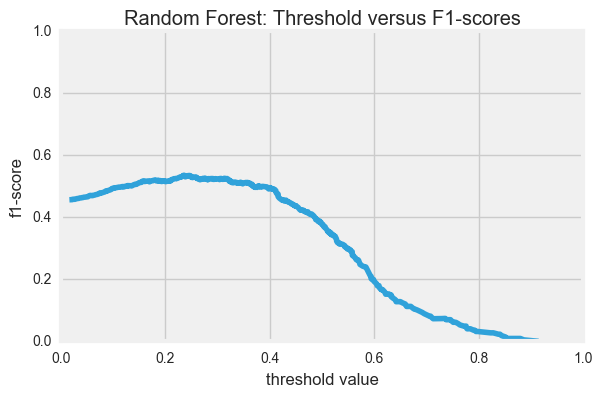

In [1397]:
plt.plot(threshold_rf, fscores)
plt.xlabel('threshold value')
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('f1-score')
plt.title('Random Forest: Threshold versus F1-scores')
threshold_rf[fscores.index(max(fscores))]

In [1398]:
precision_score(y_test,np.greater(rfmodel1_pred,0.266))

0.42120343839541546

In [1399]:
recall_score(y_test,np.greater(rfmodel1_pred,0.266))

0.68372093023255809

In [1400]:
f1_score(y_test,np.greater(rfmodel1_pred,0.266))

0.52127659574468088

In [1401]:
roc_auc_score(y_test,np.greater(rfmodel1_pred,0.266))

0.64631351448704388

In [1402]:
rfmodel1_pred

array([ 0.456,  0.326,  0.418, ...,  0.216,  0.116,  0.15 ])

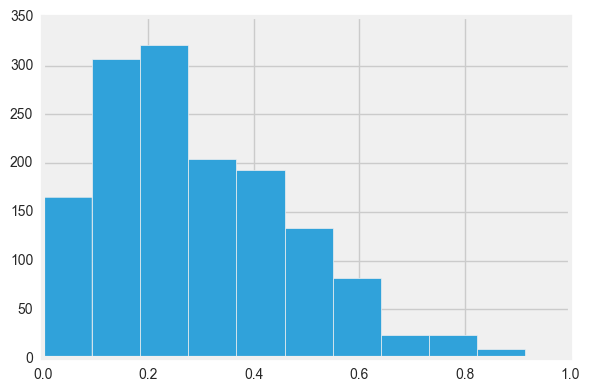

In [1403]:
plt.hist(rfmodel1_pred)#proba likelihood model thinks someone is addict (0.08 this is low)
plt.tight_layout();

In [1405]:
np.sqrt(np.mean((rfmodel1_pred - y_test)**2))

0.42931751943350333

In [1406]:
rfmodel1_pred

array([ 0.456,  0.326,  0.418, ...,  0.216,  0.116,  0.15 ])

In [1407]:
confusion_matrix(y_test,np.greater(rfmodel1_pred,0.266))

array([[629, 404],
       [136, 294]])

In [1408]:
sorted(zip(rfmodel1.feature_importances_,X_train.columns))

[(0.0034159358762188268, 'days_used_past_month'),
 (0.025543826762848554, 'last_used'),
 (0.029792313814023783, 'age_first_used'),
 (0.030101539532630429, 'age_first_alc'),
 (0.033695749906315083, 'gender'),
 (0.054041753064366489, 'days_per_week_alc'),
 (0.059999195245236704, 'days_per_week_past_year'),
 (0.068764316476802631, 'race'),
 (0.072236141155532951, 'education'),
 (0.074154142784343832, 'religious_importance'),
 (0.091080144527866058, 'age'),
 (0.10020538888679226, 'tot_days_past_year'),
 (0.1004994910062212, 'work_situation_past_wk'),
 (0.11955619861044607, 'tot_fam_income'),
 (0.13691386235035508, 'days_5plusdrinks_past_mo')]

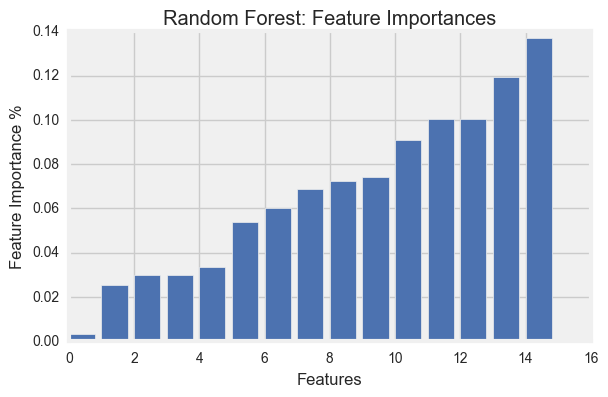

In [1409]:
plt.bar(range(15), sorted(rfmodel1.feature_importances_))
plt.ylabel('Feature Importance %')
plt.xlabel('Features')
plt.title('Random Forest: Feature Importances')

# GRADIENT BOOSTING TREE

In [1410]:
from sklearn.ensemble import GradientBoostingClassifier

In [1411]:
gbmodel1 = GradientBoostingClassifier(subsample=.8, n_estimators=1000, learning_rate=0.001, max_depth=3)
gbmodel1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [1412]:
gb1_test_pred = gbmodel1.predict_proba(X_test)[:,1]

# PLOT IT

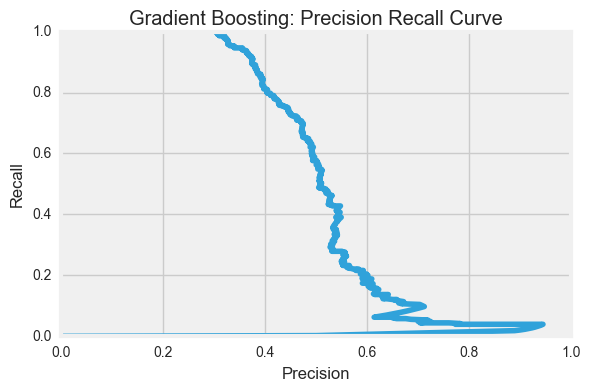

In [1414]:
precision_gb, recall_gb, threshold_gb = metrics.precision_recall_curve(y_test,gb1_test_pred)

plt.plot(precision_gb[:-1], recall_gb[:-1])
# is number of ones - recall you are leaving behind.
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Gradient Boosting: Precision Recall Curve')
plt.tight_layout();

In [1415]:
fscores2 = []
for t in threshold_gb:
    fscores2.append(f1_score(y_test,np.greater(gb1_test_pred,t)))

In [1416]:
max(fscores2)

0.56558139534883722

0.29776032843716582

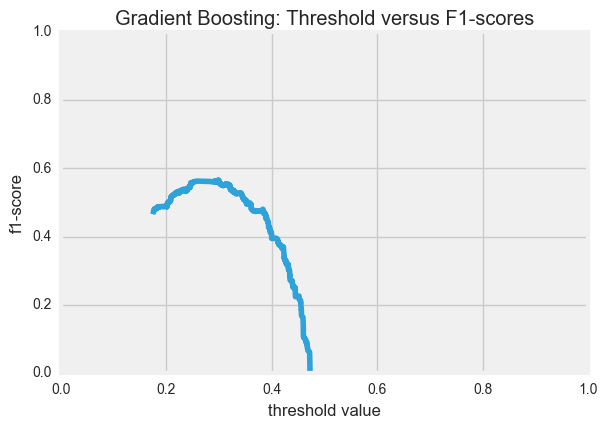

In [1417]:
plt.plot(threshold_gb, fscores2)
plt.tight_layout()

plt.xlabel('threshold value')
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('f1-score')
plt.title('Gradient Boosting: Threshold versus F1-scores')
threshold_gb[fscores2.index(max(fscores2))]
plt.tight_layout();

In [1418]:
precision_scores = []
for t in threshold_gb:
    precision_scores.append(precision_score(y_test,np.greater(gb1_test_pred,t)))

0.4674155906548414

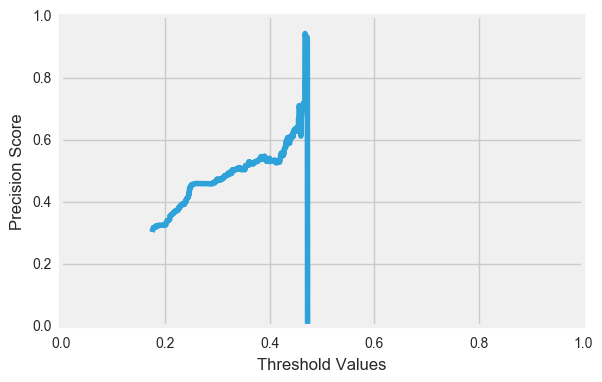

In [1419]:
plt.plot(threshold_gb, precision_scores)
plt.xlabel('Threshold Values')
plt.ylabel('Precision Score')
plt.xlim(0,1)
plt.ylim(0,1)
threshold_gb[precision_scores.index(max(precision_scores))]

# SCORE IT

In [1420]:
np.sqrt(np.mean((gb1_test_pred-y_test)**2))

0.42991218624467248

In [1421]:
precision_score(y_test,np.greater(gb1_test_pred,0.266))

0.46074074074074073

In [1422]:
recall_score(y_test,np.greater(gb1_test_pred,0.29631065461709172))

0.70930232558139539

In [1423]:
f1_score(y_test,np.greater(gb1_test_pred,0.29631065461709172))

0.5632502308402586

In [1424]:
confusion_matrix(y_test,np.greater(gb1_test_pred,0.2963))

array([[685, 348],
       [125, 305]])

In [1425]:
sorted(zip(gbmodel1.feature_importances_,X_train.columns))

[(0.0013255693714926331, 'days_per_week_alc'),
 (0.0018527527414843601, 'days_used_past_month'),
 (0.0020604596413294489, 'age_first_used'),
 (0.0033570220197059104, 'race'),
 (0.0037316806905950306, 'gender'),
 (0.0039676089559495817, 'religious_importance'),
 (0.0041842364753968027, 'days_5plusdrinks_past_mo'),
 (0.0062943706742715445, 'last_used'),
 (0.009920551579355839, 'work_situation_past_wk'),
 (0.010108393109695107, 'age_first_alc'),
 (0.014404067126926956, 'tot_fam_income'),
 (0.020701402490837063, 'days_per_week_past_year'),
 (0.035986928960934854, 'education'),
 (0.33701910621018177, 'age'),
 (0.54508584995184273, 'tot_days_past_year')]

# Feature Importances

<Container object of 15 artists>

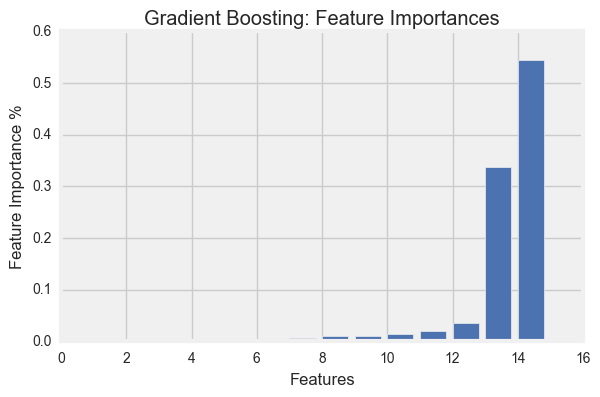

In [1426]:
plt.ylabel('Feature Importance %')
plt.xlabel('Features')
plt.title('Gradient Boosting: Feature Importances')
plt.bar(range(15), sorted(gbmodel1.feature_importances_))

In [1427]:
confusion_matrix(y_test,np.greater(rfmodel1_pred,0.266))

array([[629, 404],
       [136, 294]])

In [1428]:
confusion_matrix(y_test,np.greater(gb1_test_pred,0.296))

array([[683, 350],
       [125, 305]])